In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from collections import defaultdict
from typing import List
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
'''
hyperparameter_vectors = [
1    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
3    [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
4    [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
5    [1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5],
6    [0.1, 0.1, 0.1, 0.1, 0.5, 1.0, 2.0, 4.0],
7    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
8    [8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0],
9    [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0],
10   [128.0, 64.0, 32.0, 16.0, 8.0, 4.0, 2.0, 1.0],
11   [1.0, 1.0, 2.0, 3.0, 5.0, 8.0, 13.0, 21.0],
12   [21.0, 13.0, 8.0, 5.0, 3.0, 2.0, 1.0, 1.0],
13   [2.0, 3.0, 5.0, 7.0, 11.0, 13.0, 17.0, 19.0],
14   [19.0, 17.0, 13.0, 11.0, 7.0, 5.0, 3.0, 2.0],
15   [1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0],
16   [3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0],
17   [1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 28.0, 36.0],
18   [36.0, 28.0, 21.0, 15.0, 10.0, 6.0, 3.0, 1.0],
19   [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0],
20   [4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5],
21   [0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0],
22   [64.0, 32.0, 16.0, 8.0, 4.0, 2.0, 1.0, 0.5],
23   [1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0],
24   [4.0, 4.0, 3.0, 3.0, 2.0, 2.0, 1.0, 1.0],
25   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
26   [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
27   [1.0, 2.0, 1.5, 2.5, 2.0, 3.0, 2.5, 3.5],
28   [3.5, 2.5, 3.0, 2.0, 2.5, 1.5, 2.0, 1.0],
29   [1.0, 4.0, 1.0, 4.0, 1.0, 4.0, 1.0, 4.0],
30   [2.0, 5.0, 2.0, 5.0, 2.0, 5.0, 2.0, 5.0],
31   [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
32   [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0, 1.5],
33   [0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6]
]
'''

'\nhyperparameter_vectors = [\n1    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],\n2    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],\n3    [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3],\n4    [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n5    [1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5],\n6    [0.1, 0.1, 0.1, 0.1, 0.5, 1.0, 2.0, 4.0],\n7    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],\n8    [8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0],\n9    [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0],\n10   [128.0, 64.0, 32.0, 16.0, 8.0, 4.0, 2.0, 1.0],\n11   [1.0, 1.0, 2.0, 3.0, 5.0, 8.0, 13.0, 21.0],\n12   [21.0, 13.0, 8.0, 5.0, 3.0, 2.0, 1.0, 1.0],\n13   [2.0, 3.0, 5.0, 7.0, 11.0, 13.0, 17.0, 19.0],\n14   [19.0, 17.0, 13.0, 11.0, 7.0, 5.0, 3.0, 2.0],\n15   [1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0],\n16   [3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0],\n17   [1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 28.0, 36.0],\n18   [36.0, 28.0, 21.0, 15.0, 10.0, 6.0, 3.0, 1.0],\n19   [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0],\n20   [4.0, 3.5, 3.0, 2.5,

In [4]:
nesting_list = [2, 4, 8, 16, 32, 64, 128, 256]

config = {
    'nesting_list': nesting_list,
    'log_scale': True,
    'epochs': 20,
    'classifier_epochs': 20,
    'batch_size': 128,
    'learning_rate': 0.05 * np.sqrt(len(nesting_list)),
    'momentum': 0.9,
    'weight_decay': 5e-4
}

hyperparameter_vectors = [
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [0.353553, 0.353553, 0.353553, 0.353553, 0.353553, 0.353553, 0.353553, 0.353553],
    [0.512989, 0.461690, 0.410391, 0.359092, 0.307794, 0.256495, 0.205196, 0.153897],
    [0.153897, 0.205196, 0.256495, 0.307794, 0.359092, 0.410391, 0.461690, 0.512989],
    [0.447214, 0.223607, 0.447214, 0.223607, 0.447214, 0.223607, 0.447214, 0.223607],
    [0.021673, 0.021673, 0.021673, 0.021673, 0.108363, 0.216727, 0.433453, 0.866906],
    [0.070014, 0.140028, 0.210042, 0.280056, 0.350070, 0.420084, 0.490098, 0.560112],
    [0.560112, 0.490098, 0.420084, 0.350070, 0.280056, 0.210042, 0.140028, 0.070014],
    [0.006766, 0.013532, 0.027064, 0.054127, 0.108254, 0.216508, 0.433016, 0.866032],
    [0.866032, 0.433016, 0.216508, 0.108254, 0.054127, 0.027064, 0.013532, 0.006766],
    [0.037424, 0.037424, 0.074848, 0.112272, 0.187120, 0.299392, 0.486513, 0.785905],
    [0.785905, 0.486513, 0.299392, 0.187120, 0.112272, 0.074848, 0.037424, 0.037424],
    [0.062409, 0.093613, 0.156022, 0.218430, 0.343248, 0.405656, 0.530474, 0.592882],
    [0.592882, 0.530474, 0.405656, 0.343248, 0.218430, 0.156022, 0.093613, 0.062409],
    [0.158114, 0.474342, 0.158114, 0.474342, 0.158114, 0.474342, 0.158114, 0.474342],
    [0.474342, 0.158114, 0.474342, 0.158114, 0.474342, 0.158114, 0.474342, 0.158114],
    [0.018595, 0.055786, 0.111571, 0.185952, 0.278928, 0.390499, 0.520666, 0.669427],
    [0.669427, 0.520666, 0.390499, 0.278928, 0.185952, 0.111571, 0.055786, 0.018595],
    [0.070014, 0.140028, 0.210042, 0.280056, 0.350070, 0.420084, 0.490098, 0.560112],
    [0.560112, 0.490098, 0.420084, 0.350070, 0.280056, 0.210042, 0.140028, 0.070014],
    [0.006766, 0.013532, 0.027064, 0.054127, 0.108254, 0.216508, 0.433016, 0.866032],
    [0.866032, 0.433016, 0.216508, 0.108254, 0.054127, 0.027064, 0.013532, 0.006766],
    [0.129099, 0.129099, 0.258199, 0.258199, 0.387298, 0.387298, 0.516398, 0.516398],
    [0.516398, 0.516398, 0.387298, 0.387298, 0.258199, 0.258199, 0.129099, 0.129099],
    [0.070014, 0.140028, 0.210042, 0.280056, 0.350070, 0.420084, 0.490098, 0.560112],
    [0.560112, 0.490098, 0.420084, 0.350070, 0.280056, 0.210042, 0.140028, 0.070014],
    [0.149071, 0.298142, 0.223607, 0.372678, 0.298142, 0.447214, 0.372678, 0.521749],
    [0.521749, 0.372678, 0.447214, 0.298142, 0.372678, 0.223607, 0.298142, 0.149071],
    [0.121268, 0.485071, 0.121268, 0.485071, 0.121268, 0.485071, 0.121268, 0.485071],
    [0.185695, 0.464238, 0.185695, 0.464238, 0.185695, 0.464238, 0.185695, 0.464238],
    [0.153897, 0.205196, 0.256495, 0.307794, 0.359092, 0.410391, 0.461690, 0.512989],
    [0.512989, 0.461690, 0.410391, 0.359092, 0.307794, 0.256495, 0.205196, 0.153897],
    [0.006766, 0.013532, 0.027064, 0.054127, 0.108254, 0.216508, 0.433016, 0.866032],
]

results = []


In [5]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.mean()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=10, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits


In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


In [7]:
class ResNet9(nn.Module):
    def __init__(self, nesting_list, num_classes=10):
        super(ResNet9, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        
        self.linear = MRL_Linear_Layer(nesting_list, num_classes=num_classes, efficient=False)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def get_features(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        return out


In [8]:
class FixedFeatureClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(FixedFeatureClassifier, self).__init__()
        self.classifier = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.classifier(x)


In [9]:
def prepare_data():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, num_workers=1)
    val_loader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)
    
    return train_loader, val_loader, test_loader


In [10]:
def train(model, criterion, optimizer, train_loader, epoch, device):
    model.train()
    train_loss = 0
    correct = defaultdict(int)
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        for i, n in enumerate(model.linear.nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
            
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += targets.size(0)
    
    avg_acc = 100. * sum(correct.values()) / (total * len(model.linear.nesting_list))
        
    return train_loss/len(train_loader), avg_acc


In [11]:
def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    correct = defaultdict(int)
    total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            for i, n in enumerate(model.linear.nesting_list):
                _, predicted = outputs[i].max(1)
                correct[n] += predicted.eq(targets).sum().item()
                
            val_loss += loss.item()
            total += targets.size(0)
    
    avg_acc = 100. * sum(correct.values()) / (total * len(model.linear.nesting_list))
        
    return val_loss/len(val_loader), avg_acc


In [12]:
def extract_features(loader, model, device):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, targets in tqdm(loader, file=sys.stdout, colour='blue', ncols=120):
            inputs = inputs.to(device)
            features = model.get_features(inputs)
            features_list.append(features.cpu())
            labels_list.append(targets.cpu())
    return torch.cat(features_list), torch.cat(labels_list)


In [13]:
def train_classifiers(classifiers, optimizers, embedding_loader, device, nesting_list, epoch):
    criterion = nn.CrossEntropyLoss()
    train_losses = defaultdict(float)
    train_correct = defaultdict(int)
    train_total = 0

    for size in nesting_list:
        classifiers[size].train()

    for batch_features, batch_targets in embedding_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

        for size in nesting_list:
            optimizers[size].zero_grad()
            current_features = batch_features[:, :size].detach()
            outputs = classifiers[size](current_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizers[size].step()

            train_losses[size] += loss.item()
            _, predicted = outputs.max(1)
            train_correct[size] += predicted.eq(batch_targets).sum().item()

        train_total += batch_targets.size(0)

    train_stats = {}
    for size in nesting_list:
        train_stats[size] = {
            'loss': train_losses[size] / len(embedding_loader),
            'acc': 100. * train_correct[size] / train_total
        }

    return train_stats


In [14]:
def validate_classifiers(classifiers, embedding_loader, device, nesting_list):
    val_stats = {}
    for size in nesting_list:
        classifiers[size].eval()

    with torch.no_grad():
        for batch_features, batch_targets in embedding_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

            for size in nesting_list:
                current_features = batch_features[:, :size]
                outputs = classifiers[size](current_features)
                _, predicted = outputs.max(1)

                if size not in val_stats:
                    val_stats[size] = {'correct': 0, 'total': 0}

                val_stats[size]['correct'] += predicted.eq(batch_targets).sum().item()

            current_batch_total = batch_targets.size(0)
            for size in nesting_list:
                 if size in val_stats:
                     val_stats[size]['total'] += current_batch_total

    for size in val_stats:
        if val_stats[size]['total'] > 0:
             val_stats[size]['acc'] = 100. * val_stats[size]['correct'] / val_stats[size]['total']
        else:
             val_stats[size]['acc'] = 0.0

    return val_stats


In [15]:
def test_classifiers(classifiers, embedding_loader, device, nesting_list):
    test_stats = {}
    for size in nesting_list:
        classifiers[size].eval()

    with torch.no_grad():
        overall_total = 0
        for batch_features, batch_targets in embedding_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            current_batch_total = batch_targets.size(0)
            overall_total += current_batch_total

            for size in nesting_list:
                current_features = batch_features[:, :size]
                outputs = classifiers[size](current_features)
                _, predicted = outputs.max(1)

                if size not in test_stats:
                    test_stats[size] = {'correct_top1': 0}

                test_stats[size]['correct_top1'] += predicted.eq(batch_targets).sum().item()

    for size in nesting_list:
        test_stats[size]['total'] = overall_total

    return test_stats


In [16]:
def print_results():
    print("\nResults Summary:")
    print("┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐")
    print("│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │")
    print("├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤")
    for result in results:
        config_number = result['config_number']
        accuracies = result['accuracies']
        average_accuracy = result['average_accuracy']
        print(f"│ {config_number:14} ", end="")
        for acc in accuracies:
            print(f"│ {acc:5.1f}% ", end="")
        print(f"│ {average_accuracy:9.1f}% │")
    print("└────────────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────────┘")


In [17]:
def run_hyperparameter_search():
    train_loader, val_loader, test_loader = prepare_data()
    for idx, hyperparams in enumerate(hyperparameter_vectors, start=1):
        print(f"\n{'='*50}")
        print(f"Training with configuration #{idx}")
        print(f"{'='*50}")
        config['relative_importance'] = hyperparams
        model = ResNet9(config['nesting_list'], num_classes=10)
        criterion = Matryoshka_CE_Loss(relative_importance=config['relative_importance'])
        model = model.to(device)
        optimizer = optim.SGD(model.parameters(), 
                            lr=config['learning_rate'], 
                            momentum=config['momentum'], 
                            weight_decay=config['weight_decay'])
        scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])
        with tqdm(range(config['epochs']), desc='Training MRL model', file=sys.stdout, colour='green', ncols=120) as pbar:
            for epoch in pbar:
                train_loss, train_acc = train(model, criterion, optimizer, train_loader, epoch, device)
                val_loss, val_acc = validate(model, criterion, val_loader, device)
                scheduler.step()
                pbar.set_postfix({
                    'Train Acc': f'{train_acc:.2f}%',
                    'Val Acc': f'{val_acc:.2f}%',
                    'LR': f'{optimizer.param_groups[0]["lr"]:.5f}'
                })
        print("\nExtracting features...")
        train_features, train_labels = extract_features(train_loader, model, device)
        test_features, test_labels = extract_features(test_loader, model, device)
        embedding_batch_size = 512
        train_embedding_dataset = TensorDataset(train_features, train_labels)
        train_embedding_loader = DataLoader(train_embedding_dataset, batch_size=embedding_batch_size, shuffle=True, num_workers=1)
        test_embedding_dataset = TensorDataset(test_features, test_labels)
        test_embedding_loader = DataLoader(test_embedding_dataset, batch_size=embedding_batch_size, shuffle=False, num_workers=1)
        print("\nTraining classifiers...")
        classifiers = {}
        optimizers = {}
        schedulers = {}
        for size in config['nesting_list']:
            classifiers[size] = FixedFeatureClassifier(size, 10).to(device)
            optimizers[size] = optim.SGD(classifiers[size].parameters(), 
                                        lr=config['learning_rate'], 
                                        momentum=config['momentum'], 
                                        weight_decay=config['weight_decay'])
            schedulers[size] = CosineAnnealingLR(optimizers[size], T_max=config['classifier_epochs'])
        best_classifiers = None
        best_val_acc = 0
        with tqdm(range(config['classifier_epochs']), desc='Training classifiers', file=sys.stdout, colour='green', ncols=120) as pbar:
            for epoch in pbar:
                train_stats = train_classifiers(classifiers, optimizers, train_embedding_loader, device, config['nesting_list'], epoch)
                val_stats = validate_classifiers(classifiers, train_embedding_loader, device, config['nesting_list'])
                for size in config['nesting_list']:
                    if size in schedulers:
                        schedulers[size].step()
                avg_val_acc = sum(stats['acc'] for stats in val_stats.values()) / len(config['nesting_list'])
                if avg_val_acc > best_val_acc:
                    best_val_acc = avg_val_acc
                    best_classifiers = {size: classifiers[size] for size in config['nesting_list']}
                pbar.set_postfix({
                    'Val Acc': f'{avg_val_acc:.2f}%',
                    'Best Val Acc': f'{best_val_acc:.2f}%'
                })
        test_stats = test_classifiers(best_classifiers, test_embedding_loader, device, config['nesting_list'])
        accuracies = [100. * test_stats[size]['correct_top1'] / test_stats[size]['total'] for size in config['nesting_list']]
        avg_accuracy = sum(accuracies) / len(accuracies)
        results.append({
            'config_number': idx,
            'hyperparameters': hyperparams,
            'accuracies': accuracies,
            'average_accuracy': avg_accuracy
        })
        print("\nCurrent Results:")
        print_results()


In [18]:
def print_top_5_results():
    sorted_results = sorted(results, key=lambda x: x['average_accuracy'], reverse=True)
    print("\nTop 5 Configurations by Average Accuracy:")
    for i, result in enumerate(sorted_results[:5], start=1):
        print(f"{i}. Configuration #{result['config_number']} - Average Accuracy: {result['average_accuracy']:.2f}%")


In [19]:
def plot_comparison():
    plt.figure(figsize=(12, 6))
    
    for result in results:
        hp_str = str([f"{x:.1f}" for x in result['hyperparameters']])
        plt.plot(config['nesting_list'], result['accuracies'], 'o-', label=hp_str)
    
    plt.title('Accuracy Comparison for Different Hyperparameter Vectors')
    plt.xlabel('Feature Size')
    plt.ylabel('Top-1 Accuracy (%)')
    
    if config['log_scale']:
        plt.xscale('log')
        plt.xticks(config['nesting_list'], labels=[str(x) for x in config['nesting_list']])
    else:
        plt.xticks(config['nesting_list'])
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Нумерация векторов гиперпараметров:
1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
2: [0.353553, 0.353553, 0.353553, 0.353553, 0.353553, 0.353553, 0.353553, 0.353553]
3: [0.512989, 0.46169, 0.410391, 0.359092, 0.307794, 0.256495, 0.205196, 0.153897]
4: [0.153897, 0.205196, 0.256495, 0.307794, 0.359092, 0.410391, 0.46169, 0.512989]
5: [0.447214, 0.223607, 0.447214, 0.223607, 0.447214, 0.223607, 0.447214, 0.223607]
6: [0.021673, 0.021673, 0.021673, 0.021673, 0.108363, 0.216727, 0.433453, 0.866906]
7: [0.070014, 0.140028, 0.210042, 0.280056, 0.35007, 0.420084, 0.490098, 0.560112]
8: [0.560112, 0.490098, 0.420084, 0.35007, 0.280056, 0.210042, 0.140028, 0.070014]
9: [0.006766, 0.013532, 0.027064, 0.054127, 0.108254, 0.216508, 0.433016, 0.866032]
10: [0.866032, 0.433016, 0.216508, 0.108254, 0.054127, 0.027064, 0.013532, 0.006766]
11: [0.037424, 0.037424, 0.074848, 0.112272, 0.18712, 0.299392, 0.486513, 0.785905]
12: [0.785905, 0.486513, 0.299392, 0.18712, 0.112272, 0.074848, 0.037424, 0.037424]

Training MRL model: 100%|█████████████████| 20/20 [06:16<00:00, 18.80s/it, Train Acc=93.56%, Val Acc=88.75%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.65it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.86s/it, Val Acc=95.74%, Best Val Acc=95.75%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:15<00:00, 18.77s/it, Train Acc=93.89%, Val Acc=89.83%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.21it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.86s/it, Val Acc=94.94%, Best Val Acc=94.96%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:16<00:00, 18.84s/it, Train Acc=95.60%, Val Acc=91.09%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.96it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:01<00:00,  3.09s/it, Val Acc=96.55%, Best Val Acc=96.56%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:15<00:00, 18.75s/it, Train Acc=86.87%, Val Acc=82.57%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.02it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.89s/it, Val Acc=92.89%, Best Val Acc=92.90%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:16<00:00, 18.81s/it, Train Acc=94.36%, Val Acc=89.53%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.91it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:03<00:00,  3.15s/it, Val Acc=95.72%, Best Val Acc=95.73%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:16<00:00, 18.80s/it, Train Acc=91.34%, Val Acc=86.85%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.29it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:02<00:00,  3.14s/it, Val Acc=93.65%, Best Val Acc=93.68%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:16<00:00, 18.82s/it, Train Acc=96.03%, Val Acc=91.60%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.18it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:02<00:00,  3.14s/it, Val Acc=97.03%, Best Val Acc=97.03%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.71it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:01<00:00,  3.09s/it, Val Acc=95.98%, Best Val Acc=95.99%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.0% │  91.9% │  92.0% │  92.1% │  92.0% │  92.0% │  92.0% │      91.0% │
│              4 │  74.8% │  90.8% │  92.0% │  92.1% │  92.2% │  92.2% │ 

Training MRL model: 100%|█████████████████| 20/20 [06:15<00:00, 18.78s/it, Train Acc=95.61%, Val Acc=91.29%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.94it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:01<00:00,  3.09s/it, Val Acc=96.85%, Best Val Acc=96.87%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  81.8% │  91.4% │  92.4% │  92.6% │  92.6% │  92.6% │  92.5% │  92.6% │      91.0% │
│              2 │  78.0% │  91.2% │  92.2% │  92.3% │  92.3% │  92.3% │  92.3% │  92.3% │      90.4% │
│              3 │  85.1% │  91.

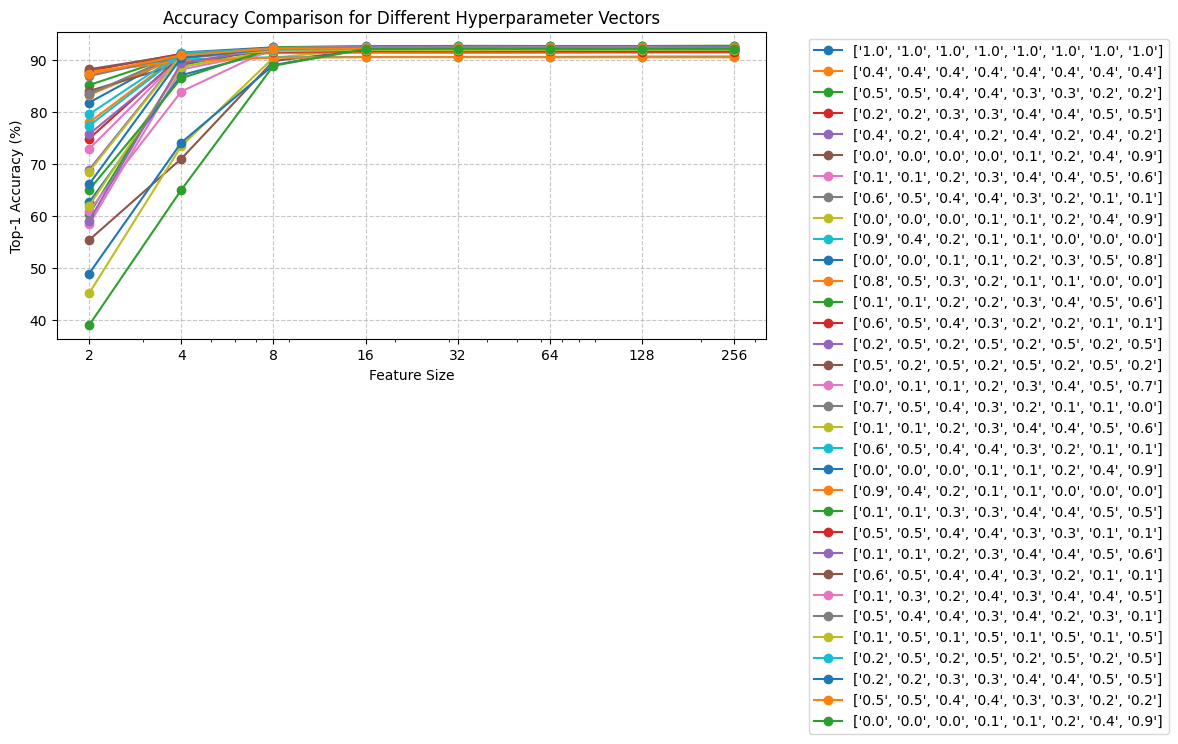


Top 5 Configurations by Average Accuracy:
1. Configuration #32 - Average Accuracy: 91.39%
2. Configuration #26 - Average Accuracy: 91.37%
3. Configuration #14 - Average Accuracy: 91.27%
4. Configuration #28 - Average Accuracy: 91.12%
5. Configuration #1 - Average Accuracy: 91.05%


In [20]:
print("Нумерация векторов гиперпараметров:")
for i, vector in enumerate(hyperparameter_vectors, start=1):
    print(f"{i}: {vector}")

run_hyperparameter_search()

print("\nFinal Results:")
print_results()
plot_comparison()
print_top_5_results()

In [20]:
# 2-nd iteration
hyperparameter_vectors = [
    [10, 8, 6, 4, 3, 2, 1.5, 1],
    [8, 7, 6, 5, 4, 3, 2.5, 2],
    [6, 5, 4, 3, 2.5, 2, 1.5, 1],
    [10, 10, 10, 5, 3, 2, 1.5, 1],
    [10, 10, 8, 8, 4, 3, 2, 1],
    [10, 8, 6.4, 5.1, 4.1, 3.3, 2.6, 2.1],
    [10, 7.5, 5.6, 4.2, 3.2, 2.4, 1.8, 1.4],
    [10, 7, 4, 3, 2.5, 2, 1.5, 1],
    [10, 9, 8, 7, 5, 3, 2, 1],
    [10, 5, 5, 5, 4, 3, 2, 1],
    [10, 10, 6, 6, 4, 3, 2, 1],
    [10, 10, 10, 5, 3, 2, 1.5, 1],
    [6, 8, 10, 8, 6, 4, 3, 2],
    [10, 9, 8, 4, 4, 3, 2, 1],
    [10, 10, 5, 5, 2, 2, 1.5, 1],
    [10, 9, 7, 5, 4, 3, 2, 1.5]
]

normalized_vectors = [np.array(v) / np.linalg.norm(v) for v in hyperparameter_vectors]

for i, (raw, norm) in enumerate(zip(hyperparameter_vectors, normalized_vectors), start=1):
    print(f"Vector #{i}:")
    print(f"  Raw:        {raw}")
    print(f"  Normalized: {[round(float(x), 4) for x in norm]}\n")

hyperparameter_vectors = normalized_vectors

Vector #1:
  Raw:        [10, 8, 6, 4, 3, 2, 1.5, 1]
  Normalized: [0.6562, 0.5249, 0.3937, 0.2625, 0.1969, 0.1312, 0.0984, 0.0656]

Vector #2:
  Raw:        [8, 7, 6, 5, 4, 3, 2.5, 2]
  Normalized: [0.553, 0.4839, 0.4148, 0.3457, 0.2765, 0.2074, 0.1728, 0.1383]

Vector #3:
  Raw:        [6, 5, 4, 3, 2.5, 2, 1.5, 1]
  Normalized: [0.6015, 0.5013, 0.401, 0.3008, 0.2506, 0.2005, 0.1504, 0.1003]

Vector #4:
  Raw:        [10, 10, 10, 5, 3, 2, 1.5, 1]
  Normalized: [0.5413, 0.5413, 0.5413, 0.2707, 0.1624, 0.1083, 0.0812, 0.0541]

Vector #5:
  Raw:        [10, 10, 8, 8, 4, 3, 2, 1]
  Normalized: [0.5285, 0.5285, 0.4228, 0.4228, 0.2114, 0.1586, 0.1057, 0.0529]

Vector #6:
  Raw:        [10, 8, 6.4, 5.1, 4.1, 3.3, 2.6, 2.1]
  Normalized: [0.6088, 0.487, 0.3896, 0.3105, 0.2496, 0.2009, 0.1583, 0.1278]

Vector #7:
  Raw:        [10, 7.5, 5.6, 4.2, 3.2, 2.4, 1.8, 1.4]
  Normalized: [0.6645, 0.4984, 0.3721, 0.2791, 0.2126, 0.1595, 0.1196, 0.093]

Vector #8:
  Raw:        [10, 7, 4, 3, 2.5, 2, 1.5

Нумерация векторов гиперпараметров:
1: [0.65617871 0.52494297 0.39370723 0.26247149 0.19685361 0.13123574
 0.09842681 0.06561787]
2: [0.5530409  0.48391079 0.41478068 0.34565056 0.27652045 0.20739034
 0.17282528 0.13826023]
3: [0.60150565 0.50125471 0.40100377 0.30075282 0.25062735 0.20050188
 0.15037641 0.10025094]
4: [0.54133196 0.54133196 0.54133196 0.27066598 0.16239959 0.10826639
 0.08119979 0.0541332 ]
5: [0.52851642 0.52851642 0.42281314 0.42281314 0.21140657 0.15855493
 0.10570328 0.05285164]
6: [0.60876102 0.48700882 0.38960705 0.31046812 0.24959202 0.20089114
 0.15827787 0.12783981]
7: [0.66452885 0.49839663 0.37213615 0.27910212 0.21264923 0.15948692
 0.11961519 0.09303404]
8: [0.73029674 0.51120772 0.2921187  0.21908902 0.18257419 0.14605935
 0.10954451 0.07302967]
9: [0.54799662 0.49319696 0.4383973  0.38359764 0.27399831 0.16439899
 0.10959932 0.05479966]
10: [0.6984303  0.34921515 0.34921515 0.34921515 0.27937212 0.20952909
 0.13968606 0.06984303]
11: [0.57543534 0.57543

Training MRL model: 100%|█████████████████| 20/20 [06:28<00:00, 19.41s/it, Train Acc=95.20%, Val Acc=90.94%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.80it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.95s/it, Val Acc=96.58%, Best Val Acc=96.58%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  87.5% │  91.0% │  91.5% │  91.7% │  91.6% │  91.7% │  91.7% │  91.7% │      91.0% │
│              2 │  88.0% │  91.3% │  92.0% │  91.9% │  91.9% │  92.0% │  92.0% │  91.9% │      91.4% │
│              3 │  86.6% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:27<00:00, 19.37s/it, Train Acc=95.37%, Val Acc=91.63%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.60it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:04<00:00,  3.22s/it, Val Acc=96.61%, Best Val Acc=96.61%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  87.5% │  91.0% │  91.5% │  91.7% │  91.6% │  91.7% │  91.7% │  91.7% │      91.0% │
│              2 │  88.0% │  91.3% │  92.0% │  91.9% │  91.9% │  92.0% │  92.0% │  91.9% │      91.4% │
│              3 │  86.6% │  91.

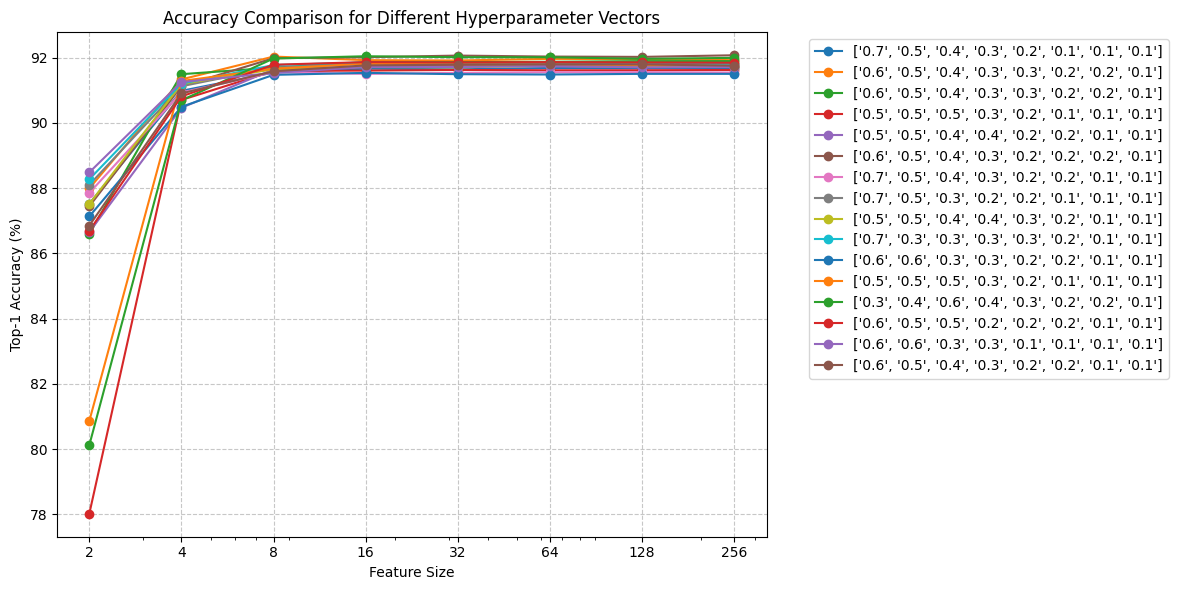


Top 5 Configurations by Average Accuracy:
1. Configuration #2 - Average Accuracy: 91.38%
2. Configuration #6 - Average Accuracy: 91.34%
3. Configuration #10 - Average Accuracy: 91.28%
4. Configuration #8 - Average Accuracy: 91.25%
5. Configuration #15 - Average Accuracy: 91.23%


In [21]:
print("Нумерация векторов гиперпараметров:")
for i, vector in enumerate(hyperparameter_vectors, start=1):
    print(f"{i}: {vector}")

run_hyperparameter_search()

print("\nFinal Results:")
print_results()
plot_comparison()
print_top_5_results()

In [27]:
from scipy.stats import ortho_group

random_orthogonal_matrix = ortho_group.rvs(dim=64)

raw_hyperparameter_vectors = random_orthogonal_matrix[:, :8]

def transform_to_positive_range(matrix, min_val=0.001, max_val=50.0):
    exp_matrix = np.exp(matrix)
    positive_matrix = exp_matrix / exp_matrix.sum(axis=1, keepdims=True)
    
    scaled_matrix = positive_matrix * (max_val - min_val) + min_val
    return scaled_matrix

raw_hyperparameter_vectors = transform_to_positive_range(raw_hyperparameter_vectors)

normalized_vectors = [v / np.linalg.norm(v) for v in raw_hyperparameter_vectors]

for i, (raw, norm) in enumerate(zip(raw_hyperparameter_vectors, normalized_vectors), start=1):
    print(f"Vector #{i}:")
    print(f"  Raw:        {raw}")
    print(f"  Normalized: {[round(float(x), 4) for x in norm]}\n")

hyperparameter_vectors = normalized_vectors

Vector #1:
  Raw:        [5.7010623  5.42018373 4.74909111 7.29776386 7.08593375 5.97245997
 6.99771776 6.78278753]
  Normalized: [0.3194, 0.3037, 0.2661, 0.4089, 0.397, 0.3346, 0.3921, 0.38]

Vector #2:
  Raw:        [6.1376918  5.13134729 6.59773625 7.00246413 5.49050296 6.45798992
 6.04964228 7.13962537]
  Normalized: [0.3453, 0.2887, 0.3712, 0.3939, 0.3089, 0.3633, 0.3403, 0.4016]

Vector #3:
  Raw:        [5.65739968 6.99360361 5.63951173 5.54352298 7.68180899 6.76089274
 6.38152798 5.34873228]
  Normalized: [0.3175, 0.3925, 0.3165, 0.3111, 0.4311, 0.3794, 0.3581, 0.3002]

Vector #4:
  Raw:        [6.23490338 6.5474173  5.44877764 6.0144718  7.76765412 5.78748336
 6.75758164 5.44871076]
  Normalized: [0.3503, 0.3679, 0.3061, 0.3379, 0.4364, 0.3252, 0.3797, 0.3061]

Vector #5:
  Raw:        [7.45217051 5.23412541 5.91288517 5.54154619 7.17837764 5.68935749
 7.7023414  5.29619619]
  Normalized: [0.4167, 0.2927, 0.3306, 0.3098, 0.4014, 0.3181, 0.4307, 0.2961]

Vector #6:
  Raw:      

Нумерация векторов гиперпараметров:
1: [0.31942523 0.30368786 0.26608717 0.40888694 0.39701829 0.33463139
 0.39207563 0.38003329]
2: [0.34527744 0.28866527 0.37115736 0.39392543 0.30886967 0.3632959
 0.34032419 0.40164148]
3: [0.31749888 0.39248797 0.31649499 0.311108   0.43111073 0.379428
 0.35813768 0.30017616]
4: [0.35030283 0.36786116 0.30613501 0.33791806 0.43641915 0.32516491
 0.37966907 0.30613125]
5: [0.41667005 0.29265344 0.33060464 0.30984212 0.40136159 0.31810663
 0.43065775 0.29612397]
6: [0.4599055  0.35851929 0.29056235 0.39212692 0.32745506 0.39991894
 0.29542041 0.25947187]
7: [0.40564556 0.3692122  0.306731   0.2965535  0.35667747 0.34445967
 0.33002872 0.40288448]
8: [0.33211198 0.3276868  0.38361722 0.38007444 0.37029182 0.34704146
 0.36224212 0.31926648]
9: [0.29436227 0.43479173 0.37493171 0.36814316 0.34640109 0.31995089
 0.33166527 0.34035231]
10: [0.39511475 0.3770257  0.31021522 0.34289352 0.31792762 0.37832951
 0.36501401 0.33238545]
11: [0.40429915 0.35865664

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.98s/it, Train Acc=94.44%, Val Acc=90.20%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.13it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.91s/it, Val Acc=96.12%, Best Val Acc=96.12%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.01s/it, Train Acc=93.80%, Val Acc=89.97%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.38it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=96.05%, Best Val Acc=96.06%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.99s/it, Train Acc=95.63%, Val Acc=91.43%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.47it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=96.92%, Best Val Acc=96.92%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.01s/it, Train Acc=95.34%, Val Acc=90.80%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.60it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.90s/it, Val Acc=96.83%, Best Val Acc=96.83%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.99s/it, Train Acc=93.72%, Val Acc=89.81%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.61it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.95s/it, Val Acc=95.25%, Best Val Acc=95.28%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.02s/it, Train Acc=94.78%, Val Acc=90.85%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.35it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=96.36%, Best Val Acc=96.42%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:18<00:00, 18.93s/it, Train Acc=94.37%, Val Acc=90.03%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.71it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.87s/it, Val Acc=96.09%, Best Val Acc=96.09%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.93s/it, Val Acc=96.60%, Best Val Acc=96.61%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.0% │  91.9% │  91.9% │  91.9% │  92.0% │  91.9% │  92.0% │      90.4% │
│              4 │  81.9% │  90.4% │  91.8% │  92.0% │  92.1% │  92.1% │  92.0% │  92.1% │      90.6% │
│              5 │  84.9% │  91.1% │  91.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │      91.0% │
│          

Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.88s/it, Val Acc=96.82%, Best Val Acc=96.84%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.0% │  91.9% │  91.9% │  91.9% │  92.0% │  91.9% │  92.0% │      90.4% │
│              4 │  81.9% │  90.4% │  91.8% │  92.0% │  92.1% │  92.1% │  92.0% │  92.1% │      90.6% │
│              5 │  84.9% │  91.1% │  91.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │      91.0% │
│          

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.29it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.93s/it, Val Acc=95.63%, Best Val Acc=95.67%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.0% │  91.9% │  91.9% │  91.9% │  92.0% │  91.9% │  92.0% │      90.4% │
│              4 │  81.9% │  90.4% │  91.8% │  92.0% │  92.1% │  92.1% │ 

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.00s/it, Train Acc=93.92%, Val Acc=90.03%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.66it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:59<00:00,  2.96s/it, Val Acc=95.44%, Best Val Acc=95.46%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.02s/it, Train Acc=95.09%, Val Acc=90.91%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.93it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.91s/it, Val Acc=96.59%, Best Val Acc=96.63%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.98s/it, Train Acc=94.99%, Val Acc=90.77%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.33it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.90s/it, Val Acc=96.05%, Best Val Acc=96.05%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.98s/it, Train Acc=94.84%, Val Acc=90.71%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.28it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=96.59%, Best Val Acc=96.62%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.99s/it, Train Acc=95.75%, Val Acc=91.65%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.50it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.89s/it, Val Acc=97.07%, Best Val Acc=97.08%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.02s/it, Train Acc=94.85%, Val Acc=90.19%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.19it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:03<00:00,  3.18s/it, Val Acc=96.94%, Best Val Acc=96.95%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.98s/it, Train Acc=96.15%, Val Acc=91.98%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.12it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.93s/it, Val Acc=97.09%, Best Val Acc=97.10%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.02s/it, Train Acc=95.21%, Val Acc=91.12%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.29it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:03<00:00,  3.19s/it, Val Acc=96.84%, Best Val Acc=96.84%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 19.00s/it, Train Acc=95.68%, Val Acc=91.60%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.24it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:56<00:00,  2.83s/it, Val Acc=96.97%, Best Val Acc=96.98%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.03s/it, Train Acc=95.07%, Val Acc=90.36%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.42it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:04<00:00,  3.20s/it, Val Acc=96.55%, Best Val Acc=96.56%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.97s/it, Train Acc=95.81%, Val Acc=91.50%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.29it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=97.04%, Best Val Acc=97.04%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:21<00:00, 19.07s/it, Train Acc=94.82%, Val Acc=90.52%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.75it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:03<00:00,  3.17s/it, Val Acc=96.68%, Best Val Acc=96.69%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.97s/it, Train Acc=93.94%, Val Acc=89.79%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.38it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:03<00:00,  3.18s/it, Val Acc=95.64%, Best Val Acc=95.64%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.98s/it, Train Acc=93.87%, Val Acc=89.51%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.58it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:04<00:00,  3.23s/it, Val Acc=95.80%, Best Val Acc=95.87%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.96s/it, Train Acc=95.64%, Val Acc=91.42%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.44it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:04<00:00,  3.23s/it, Val Acc=97.01%, Best Val Acc=97.01%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.01s/it, Train Acc=93.95%, Val Acc=89.80%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.77it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [01:04<00:00,  3.22s/it, Val Acc=95.88%, Best Val Acc=95.88%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training classifiers: 100%|████████████████████████| 20/20 [01:03<00:00,  3.17s/it, Val Acc=96.69%, Best Val Acc=96.70%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.0% │  91.9% │  91.9% │  91.9% │  92.0% │  91.9% │  92.0% │      90.4% │
│              4 │  81.9% │  90.4% │  91.8% │  92.0% │  92.1% │  92.1% │  92.0% │  92.1% │      90.6% │
│              5 │  84.9% │  91.1% │  91.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │      91.0% │
│          

/tmp/ipykernel_1177034/739385607.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


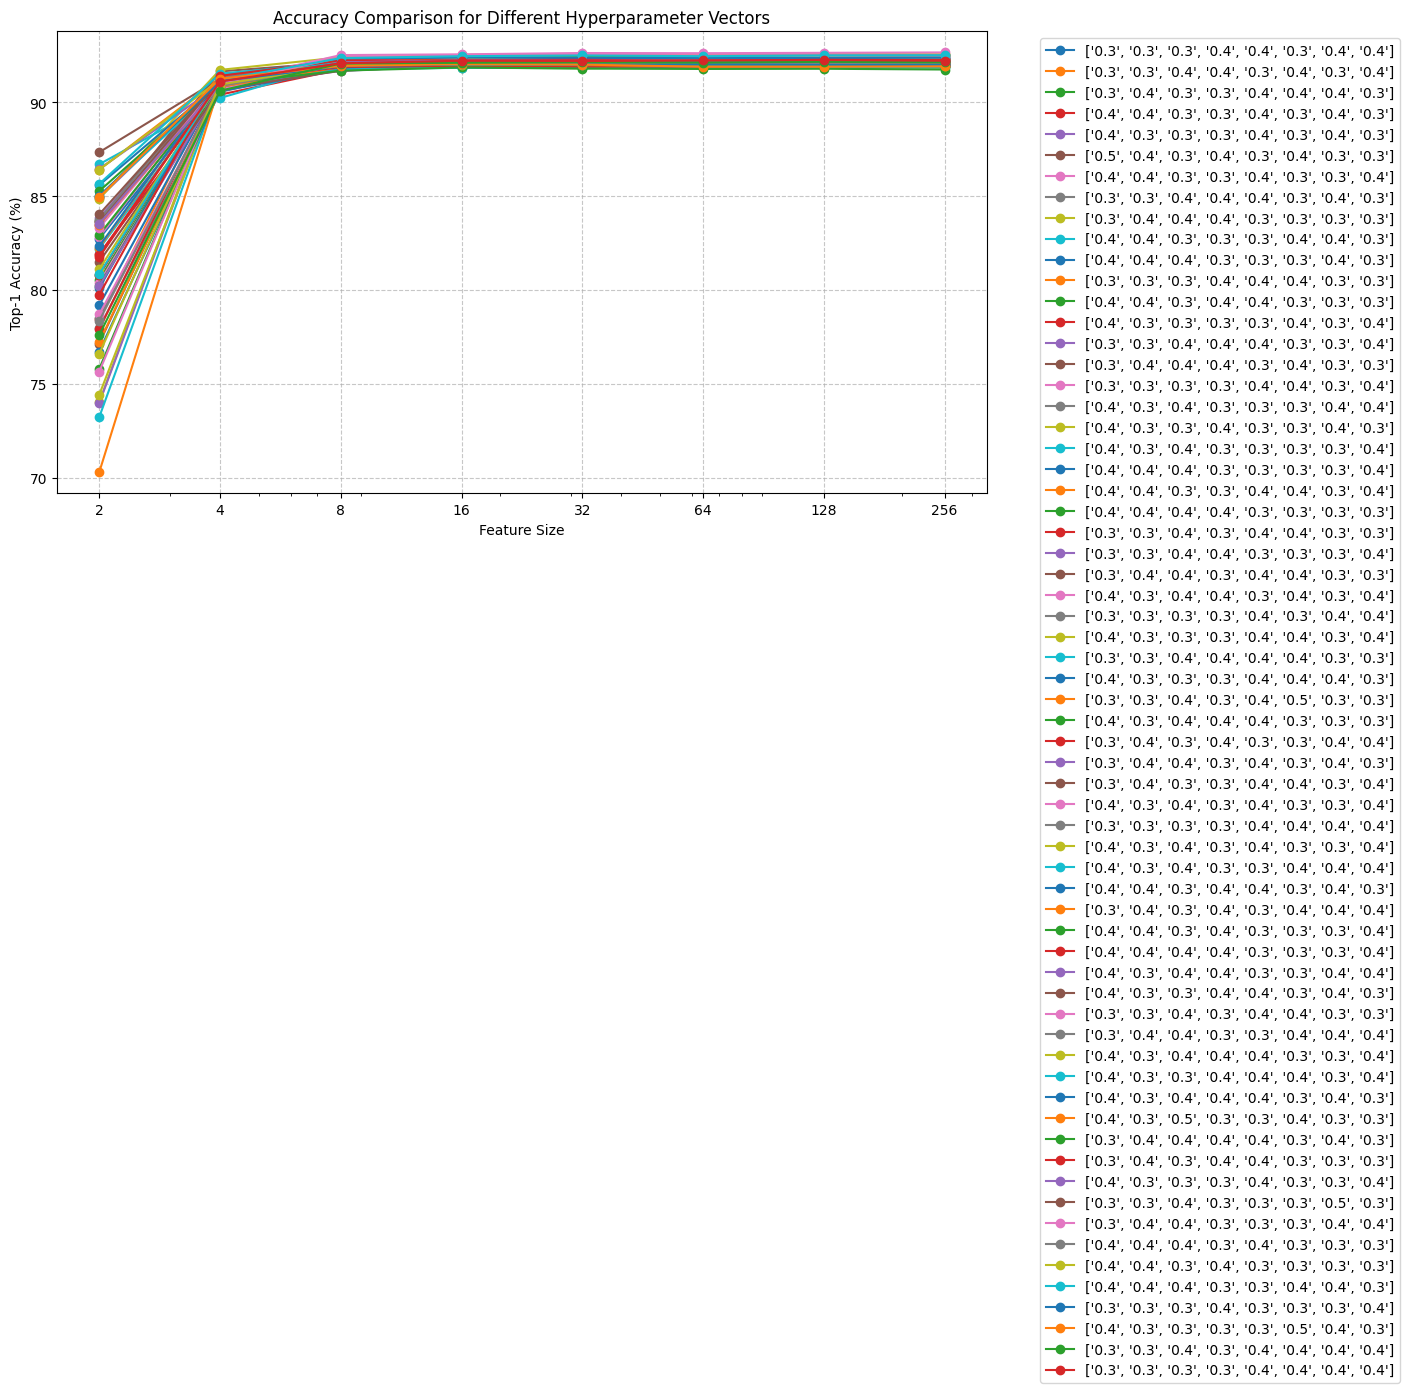


Top 5 Configurations by Average Accuracy:
1. Configuration #6 - Average Accuracy: 91.66%
2. Configuration #29 - Average Accuracy: 91.45%
3. Configuration #12 - Average Accuracy: 91.39%
4. Configuration #49 - Average Accuracy: 91.32%
5. Configuration #50 - Average Accuracy: 91.31%


In [28]:
print("Нумерация векторов гиперпараметров:")
for i, vector in enumerate(hyperparameter_vectors, start=1):
    print(f"{i}: {vector}")

run_hyperparameter_search()

print("\nFinal Results:")
print_results()
plot_comparison()
print_top_5_results()

In [29]:
def print_worst_5_results():
    sorted_results = sorted(results, key=lambda x: x['average_accuracy'], reverse=False)
    print("\nTop 5 Configurations by Average Accuracy:")
    for i, result in enumerate(sorted_results[:5], start=1):
        print(f"{i}. Configuration #{result['config_number']} - Average Accuracy: {result['average_accuracy']:.2f}%")


In [30]:
print_worst_5_results()


Top 5 Configurations by Average Accuracy:
1. Configuration #32 - Average Accuracy: 89.25%
2. Configuration #30 - Average Accuracy: 89.77%
3. Configuration #15 - Average Accuracy: 89.79%
4. Configuration #19 - Average Accuracy: 89.82%
5. Configuration #31 - Average Accuracy: 89.88%


In [31]:
base_vector = [1.0] * 8

hyperparameter_vectors = []
varying_values = [0.1, 1, 10]

for i in range(8):
    for value in varying_values:
        new_vector = base_vector.copy()
        new_vector[i] = value
        hyperparameter_vectors.append(new_vector)

normalized_vectors = [np.array(v) / np.linalg.norm(v) for v in hyperparameter_vectors]

for i, (raw, norm) in enumerate(zip(hyperparameter_vectors, normalized_vectors), start=1):
    print(f"Vector #{i}:")
    print(f"  Raw:        {raw}")
    print(f"  Normalized: {[round(float(x), 4) for x in norm]}\n")

hyperparameter_vectors = normalized_vectors


Vector #1:
  Raw:        [0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  Normalized: [0.0378, 0.3777, 0.3777, 0.3777, 0.3777, 0.3777, 0.3777, 0.3777]

Vector #2:
  Raw:        [1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  Normalized: [0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536]

Vector #3:
  Raw:        [10, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  Normalized: [0.9667, 0.0967, 0.0967, 0.0967, 0.0967, 0.0967, 0.0967, 0.0967]

Vector #4:
  Raw:        [1.0, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  Normalized: [0.3777, 0.0378, 0.3777, 0.3777, 0.3777, 0.3777, 0.3777, 0.3777]

Vector #5:
  Raw:        [1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  Normalized: [0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536, 0.3536]

Vector #6:
  Raw:        [1.0, 10, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  Normalized: [0.0967, 0.9667, 0.0967, 0.0967, 0.0967, 0.0967, 0.0967, 0.0967]

Vector #7:
  Raw:        [1.0, 1.0, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0]
  Normalized: [0.3777, 0.3777, 0.0378, 0.3777, 0.3777, 0.3777, 0

Нумерация векторов гиперпараметров:
1: [0.03776948 0.37769479 0.37769479 0.37769479 0.37769479 0.37769479
 0.37769479 0.37769479]
2: [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
3: [0.96673649 0.09667365 0.09667365 0.09667365 0.09667365 0.09667365
 0.09667365 0.09667365]
4: [0.37769479 0.03776948 0.37769479 0.37769479 0.37769479 0.37769479
 0.37769479 0.37769479]
5: [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
6: [0.09667365 0.96673649 0.09667365 0.09667365 0.09667365 0.09667365
 0.09667365 0.09667365]
7: [0.37769479 0.37769479 0.03776948 0.37769479 0.37769479 0.37769479
 0.37769479 0.37769479]
8: [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
9: [0.09667365 0.09667365 0.96673649 0.09667365 0.09667365 0.09667365
 0.09667365 0.09667365]
10: [0.37769479 0.37769479 0.37769479 0.03776948 0.37769479 0.37769479
 0.37769479 0.37769479]
11: [0.35355339 0.35355

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.03s/it, Train Acc=95.21%, Val Acc=89.90%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.15it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=96.43%, Best Val Acc=96.48%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.43it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=95.05%, Best Val Acc=95.06%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.0% │  91.9% │  91.9% │  91.9% │  92.0% │  91.9% │  92.0% │      90.4% │
│              4 │  81.9% │  90.4% │  91.8% │  92.0% │  92.1% │  92.1% │ 

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.48it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.89s/it, Val Acc=96.05%, Best Val Acc=96.05%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.0% │  91.9% │  91.9% │  91.9% │  92.0% │  91.9% │  92.0% │      90.4% │
│              4 │  81.9% │  90.4% │  91.8% │  92.0% │  92.1% │  92.1% │ 

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.99s/it, Train Acc=95.76%, Val Acc=90.11%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.54it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.88s/it, Val Acc=97.16%, Best Val Acc=97.16%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.95s/it, Train Acc=90.70%, Val Acc=85.84%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.26it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.88s/it, Val Acc=93.45%, Best Val Acc=93.69%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 19.00s/it, Train Acc=95.06%, Val Acc=89.29%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.23it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.89s/it, Val Acc=96.18%, Best Val Acc=96.20%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.01s/it, Train Acc=94.61%, Val Acc=89.39%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.26it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=96.01%, Best Val Acc=96.03%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.98s/it, Train Acc=90.77%, Val Acc=85.71%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.53it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.88s/it, Val Acc=94.50%, Best Val Acc=94.60%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.99s/it, Train Acc=95.37%, Val Acc=90.25%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.13it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:59<00:00,  2.95s/it, Val Acc=96.71%, Best Val Acc=96.71%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.04s/it, Train Acc=96.09%, Val Acc=90.63%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.49it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.91s/it, Val Acc=97.17%, Best Val Acc=97.18%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.96s/it, Train Acc=91.06%, Val Acc=85.45%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.13it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.88s/it, Val Acc=93.89%, Best Val Acc=93.91%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.97s/it, Train Acc=94.97%, Val Acc=89.42%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.41it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:59<00:00,  2.96s/it, Val Acc=96.16%, Best Val Acc=96.26%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.97s/it, Train Acc=95.79%, Val Acc=90.21%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.23it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.93s/it, Val Acc=97.12%, Best Val Acc=97.12%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.98s/it, Train Acc=90.49%, Val Acc=85.71%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.09it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=93.70%, Best Val Acc=93.75%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.02s/it, Train Acc=95.23%, Val Acc=89.88%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.58it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.88s/it, Val Acc=96.18%, Best Val Acc=96.22%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.96s/it, Train Acc=94.07%, Val Acc=88.81%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.46it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.94s/it, Val Acc=95.59%, Best Val Acc=95.60%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.96s/it, Train Acc=91.21%, Val Acc=86.42%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.94it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.89s/it, Val Acc=94.06%, Best Val Acc=94.06%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.04s/it, Train Acc=95.31%, Val Acc=90.10%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.28it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:58<00:00,  2.92s/it, Val Acc=96.26%, Best Val Acc=96.27%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.02s/it, Train Acc=94.04%, Val Acc=88.33%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.03it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.88s/it, Val Acc=96.06%, Best Val Acc=96.06%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.99s/it, Train Acc=91.37%, Val Acc=86.13%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.30it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:59<00:00,  2.95s/it, Val Acc=95.15%, Best Val Acc=95.18%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:19<00:00, 18.99s/it, Train Acc=95.51%, Val Acc=90.22%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.50it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:59<00:00,  2.96s/it, Val Acc=96.98%, Best Val Acc=96.99%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.00s/it, Train Acc=94.74%, Val Acc=89.32%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.22it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.89s/it, Val Acc=96.42%, Best Val Acc=96.44%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

Training MRL model: 100%|█████████████████| 20/20 [06:20<00:00, 19.03s/it, Train Acc=92.43%, Val Acc=87.26%, LR=0.00000]

Extracting features...
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.18it/s]

Training classifiers...
Training classifiers: 100%|████████████████████████| 20/20 [00:57<00:00,  2.89s/it, Val Acc=95.89%, Best Val Acc=95.89%]

Current Results:

Results Summary:
┌────────────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│ Config Number  │      2 │      4 │      8 │     16 │     32 │     64 │    128 │    256 │   Average  │
├────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│              1 │  82.7% │  90.8% │  91.9% │  92.0% │  92.0% │  92.0% │  92.0% │  92.0% │      90.7% │
│              2 │  78.4% │  91.5% │  92.1% │  92.2% │  92.2% │  92.2% │  92.2% │  92.2% │      90.4% │
│              3 │  80.5% │  91.

/tmp/ipykernel_1177034/739385607.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


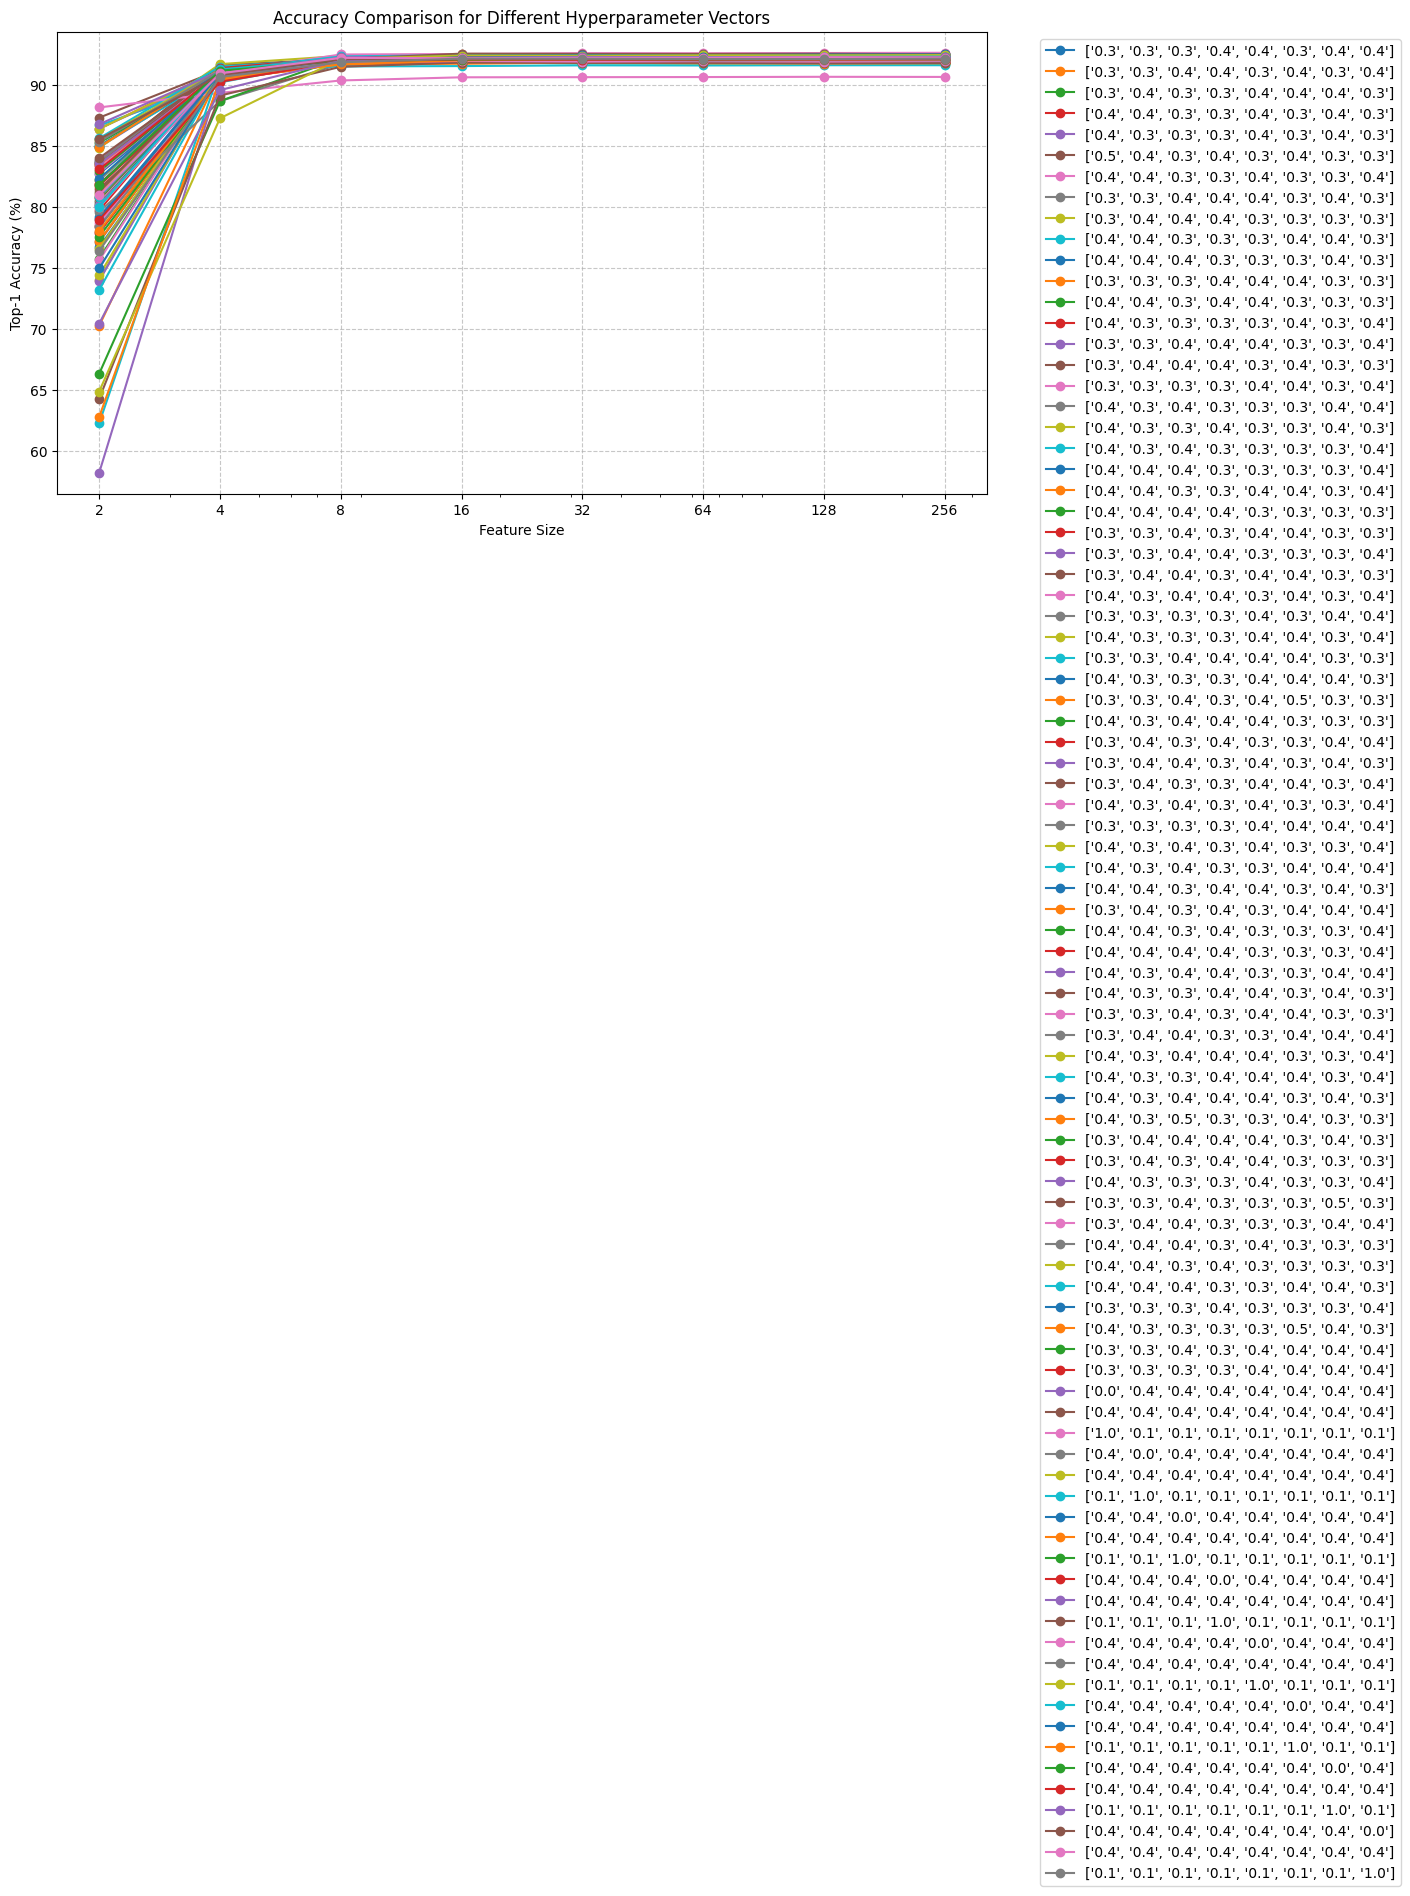


Top 5 Configurations by Average Accuracy:
1. Configuration #6 - Average Accuracy: 91.66%
2. Configuration #11 - Average Accuracy: 91.46%
3. Configuration #29 - Average Accuracy: 91.45%
4. Configuration #12 - Average Accuracy: 91.39%
5. Configuration #49 - Average Accuracy: 91.32%
Worst

Top 5 Configurations by Average Accuracy:
1. Configuration #1 - Average Accuracy: 87.87%
2. Configuration #6 - Average Accuracy: 87.90%
3. Configuration #12 - Average Accuracy: 88.02%
4. Configuration #18 - Average Accuracy: 88.19%
5. Configuration #15 - Average Accuracy: 88.32%


In [32]:
print("Нумерация векторов гиперпараметров:")
for i, vector in enumerate(hyperparameter_vectors, start=1):
    print(f"{i}: {vector}")

run_hyperparameter_search()

print("\nFinal Results:")
print_results()
plot_comparison()
print_top_5_results()
print("Worst")
print_worst_5_results()